In [1]:
import numpy as np

# Function to read ASCII raster file
def read_asc_file(file_path):
    # Read header information
    with open(file_path, 'r') as f:
        ncols = None
        nrows = None
        xllcorner = None
        yllcorner = None
        cellsize = None
        nodata_value = None

        for line in f:
            line = line.strip().split()
            if len(line) == 2:
                if line[0].lower() == 'ncols':
                    ncols = int(line[1])
                elif line[0].lower() == 'nrows':
                    nrows = int(line[1])
                elif line[0].lower() == 'xllcorner':
                    xllcorner = float(line[1])
                elif line[0].lower() == 'yllcorner':
                    yllcorner = float(line[1])
                elif line[0].lower() == 'cellsize':
                    cellsize = float(line[1])
                elif line[0].lower() == 'nodata_value':
                    nodata_value = float(line[1])
            else:
                break

    # Read data values
    data = np.genfromtxt(file_path, skip_header=6)

    return {
        'ncols': ncols,
        'nrows': nrows,
        'xllcorner': xllcorner,
        'yllcorner': yllcorner,
        'cellsize': cellsize,
        'nodata_value': nodata_value,
        'data': data
    }


In [2]:
import matplotlib.pyplot as plt

In [3]:
# Example usage
file_path = r"C:\Users\20230008\Documents\Study\AI_CFD\SWE\depth_265.asc"
data = read_asc_file(file_path)
print(data["data"])
print(data["data"].shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(722, 417)


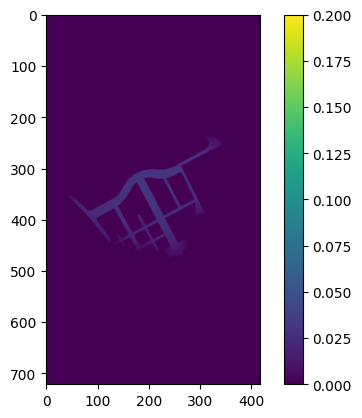

In [4]:
plt.figure()
plt.imshow(data["data"])
plt.clim(0.0,0.2)
plt.colorbar()

In [5]:
data_np = np.array(data["data"])

In [8]:
def avg_pool(arr):
    arr = np.pad(arr, ((0, 0), (0, 1)), mode='constant')
    x, y = arr.shape
    new_x, new_y = x//2, y//2
    arr = np.mean(arr.reshape(new_x, 2, new_y, 2), axis=(1, 3))
    return arr

(361, 209)


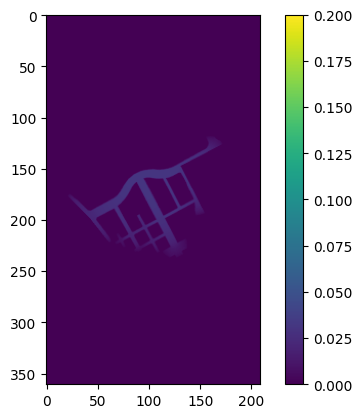

In [10]:
print(avg_pool(data_np).shape)
plt.imshow(avg_pool(data_np))
plt.clim(0.0,0.2)
plt.colorbar()

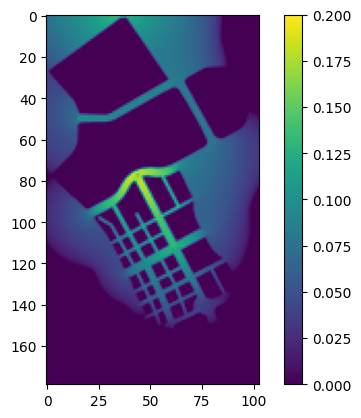

In [19]:
plt.imshow(avg_pool(avg_pool(data_np)))
plt.clim(0.0,0.2)
plt.colorbar()

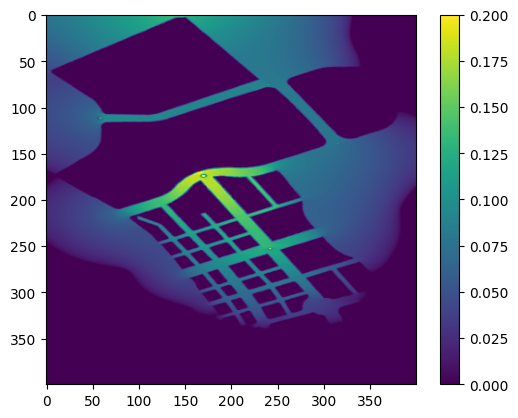

In [21]:
from skimage.transform import resize
plt.imshow(resize(data_np, (400, 400)))
plt.clim(0.0,0.2)
plt.colorbar()

In [ ]:
from dataloader import CustomDataset
import torch

root_pth = ""

dataset = CustomDataset(root_pth)
means = 0
stds = 0

for d in len(dataset):
    mean = torch.mean(d, dim=(1, 2))
    std = torch.std(d, dim=(1, 2))

    means += mean
    stds += std

means /= len(dataset)
stds /= len(dataset)

print("Overall mean of each channel (depth, xvel, yvel):", means)
print("Overall standard deviation of each channel (depth, xvel, yvel):", stds)